# Analysis ver4

Modifed from ver3 to create a better model.  Uses pipelines extensively.

In [1]:
%matplotlib inline

In [2]:
cd /home/tobiszuts/insight/project

/media/tobiszuts/Windows/Data/Work/Insight/project


In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data cleaning

Get the data and start processing.

In [4]:
file_load = "Reddit_depression.p"
results = pickle.load( open(file_load, 'rb'))

## Create Features

In [5]:
def PreProcessData_training(raw_data) :
    """ This processes the post data, and can be used as 
    a template for the upload data.
    """
    import pandas as pd
    
    data_raw = pd.DataFrame(raw_data)
    # some of these columns aren't being used to create features yet
    extract_keys = ['num_comments', 'created_utc', 'title', 'selftext']
    data = data_raw[sorted(extract_keys)].copy()
    
    # remove all rows without any valid text
    data = data[data.selftext.map(len) > 0]
            
    dates = pd.to_datetime(data.created_utc, unit="s")
    data['created_dayofweek'] = dates.dt.dayofweek
    data['created_hour'] = dates.dt.hour
    data['created_month'] = dates.dt.month
    data['created_year'] = dates.dt.year
    cut_off_year = 2011
    data = data[ data.created_year > cut_off_year]
    print('Removing all posts before 2011.')
    
    data['post_char_len'] = data.selftext.apply(lambda x: len(x))
    data['post_num_qs'] = data.selftext.apply(lambda x: x.count('?'))
    data['title_char_len'] = data.title.apply(lambda x: len(x))
    data['title_num_qs'] = data.title.apply(lambda x: x.count('?'))
    
    def CountPostPunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['selftext'] :
            if char in punc_set :
                num_punc += 1
        return num_punc
    def CountTitlePunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['title'] :
            if char in punc_set :
                num_punc += 1
        return num_punc

    data['post_num_punc'] = data.apply(CountPostPunctuation, axis=1)
    data['title_num_punc'] = data.apply(CountTitlePunctuation, axis=1)
    data['post_perc_punc'] = data.post_num_punc / data.post_char_len
    data['title_perc_punc'] = data.title_num_punc / data.title_char_len
    data.post_perc_punc = data.post_perc_punc.fillna(0)
    print('Earliest post = {}'.format(pd.to_datetime(data.created_utc.min(), unit="s")))

    # get rid of columns that aren't needed for the model
    drop_cols = ['created_utc',]
        
    return data.drop(drop_cols, axis=1)

The following function takes about 20 seconds to run on the whole data set.

In [7]:
data_clean = PreProcessData_training(results)
print('There are {} posts after processing.'.format(len(data_clean)))
data_clean.head()

Removing all posts before 2011.
Earliest post = 2012-01-01 00:41:48
There are 73724 posts after processing.


,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,post_perc_punc,title_perc_punc
0,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1,42,0,34,2,0.045515,0.047619
1,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5,72,0,43,4,0.054499,0.055556
2,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0,40,0,25,2,0.032425,0.050000
3,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1,40,1,19,1,0.056380,0.025000
4,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0,16,0,0,0,0.000000,0.000000


# NLP pre-processing

Create the corpus from the text post.  Limit to 20,000 to make processing easier.

In [8]:
data_clean = data_clean[:20000]

All processing in one function.

In [9]:
from gensim import corpora, models, similarities

def CreateCorpus(raw_text) :
    """ Create a corpus from an array of documents (each document
        a string).  It expects it as a python object, not a pandas
        one.  Returns an array of tokenized texts and the corpus dictionary.
    """
    from gensim import corpora, models, similarities
    from nltk.tokenize import WordPunctTokenizer
    import string
    from nltk.stem.snowball import SnowballStemmer
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    word_punct_tokenizer = WordPunctTokenizer()
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    texts_proc = []
    for text in raw_text :
        words = word_punct_tokenizer.tokenize(text)
        words = [w for w in words if (w not in stop_words)]
        texts_proc.append([stemmer.stem(w.lower()) for w in words 
                                if not all(c in punctuation for c in w)])
        
    # create dictionary
    corpus_dictionary = corpora.Dictionary(texts_proc)
    corpus_dictionary.filter_extremes(no_below=3, no_above=0.5)
    print(corpus_dictionary)
    
    return texts_proc, corpus_dictionary

In [10]:
# takes ~5 minutes to run
posts_raw = list(data_clean.selftext)
titles_raw = list(data_clean.title)
(all_tokenized, all_dictionary) = CreateCorpus(posts_raw + titles_raw)
posts_tokenized = all_tokenized[:len(posts_raw)]
titles_tokenized = all_tokenized[len(posts_raw):]

Dictionary(11384 unique tokens: ['think', 'straight', 'concentr', 'feel', 'like']...)


Previously (with stop words, no stemming, and extra punctuation, and all 90k posts), dictionary had 80k terms.  With all that filtering, it now has 20k terms.  With only 20k posts, it has 11k terms.

In [11]:
posts_vec = [all_dictionary.doc2bow(post) for post in posts_tokenized]
titles_vec = [all_dictionary.doc2bow(post) for post in titles_tokenized]

Create a couple more features.  Note that the word tokenization here is pretty basic, just splitting on white space, and could definitely be improved.

In [12]:
def AddWordFeatures(dataframe, posts_raw, posts_vec, titles_raw, titles_vec) :
    """ Add some word related features to the dataframe.
        Arguments: X_raw is the raw data without any process.  X_vec is the vectorized
        version of that, which has stop words and punctuation removed.
    """
    dataframe_new = dataframe.copy()
    dataframe_new = dataframe_new.assign(post_word_len1 = [len(post.split()) for post in posts_raw] )
    dataframe_new = dataframe_new.assign(post_word_len2 = [len(post) for post in posts_vec] )
    
    dataframe_new = dataframe_new.assign(title_word_len1 = [len(post.split()) for post in titles_raw] )
    dataframe_new = dataframe_new.assign(title_word_len2 = [len(post) for post in titles_vec] )
    return dataframe_new

In [13]:
data_clean = AddWordFeatures(data_clean, posts_raw, posts_vec, titles_raw, titles_vec)

## Latent Semantic Analysis

This is effectively PCA on the tfidf vectors to cluster them.  Use the Gensim implementation.

In [14]:
from gensim.models import lsimodel
num_lsi_topics = 400
print(all_dictionary)

Dictionary(11384 unique tokens: ['think', 'straight', 'concentr', 'feel', 'like']...)


In [15]:
post_lsi = lsimodel.LsiModel(posts_vec, num_topics=num_lsi_topics, id2word=all_dictionary)
title_lsi = lsimodel.LsiModel(titles_vec, num_topics=num_lsi_topics, id2word=all_dictionary)

In [16]:
def ComputeDocumentLSIs(documents, lsi, N, label_base = 'lsi') : 
    " Compute the LSI representation of every document in the corpus"
    baseline = [0 for x in range(N)]
    col_labels = ['{}_{}'.format(label_base, x) for x in range(N)]
    new_features = pd.DataFrame([], columns=col_labels)
    for (x, text) in enumerate(documents) :
        if len(text) > 0:
            lsi_temp = lsi[text]
            if len(lsi_temp) == N :
                temp = [y for (z,y) in lsi_temp]
                new_features.loc[x] = temp
            else :
                #print(x, len(temp))
                new_features.loc[x] = baseline
        else :
            new_features.loc[x] = baseline
    return new_features

The following has a funny issue: the title LSI features sometimes get returned as a vector with fewer dimensions than N.  For N=100, it goes as low as 93, primarily when the number of words, after stemming, is either 1 or 2.

In [17]:
# this takes 85 s for 20k posts and 20 topics, 154 s for 20k and 100, 950 s for 20k and 400
import time
start_time = time.time()

post_lsi_features = ComputeDocumentLSIs(posts_vec, post_lsi, num_lsi_topics, label_base = 'post_lsi')
title_lsi_features = ComputeDocumentLSIs(titles_vec, title_lsi, num_lsi_topics, label_base = 'title_lsi')

print("--- %s seconds ---" % (time.time() - start_time))  
post_lsi_features.head()

--- 952.9912796020508 seconds ---


,post_lsi_0,post_lsi_1,post_lsi_2,post_lsi_3,post_lsi_4,post_lsi_5,post_lsi_6,post_lsi_7,post_lsi_8,post_lsi_9,...,post_lsi_390,post_lsi_391,post_lsi_392,post_lsi_393,post_lsi_394,post_lsi_395,post_lsi_396,post_lsi_397,post_lsi_398,post_lsi_399
0,3.828536,0.633560,-1.490601,-0.309393,-0.148547,-0.246853,1.016618,0.834225,-0.186890,0.210056,...,0.242957,0.097501,-0.185518,0.074859,0.338405,0.104274,0.271242,-0.108324,-0.058139,0.032553
1,4.362322,0.512693,-1.459977,1.983097,-0.871054,-0.916573,-2.331113,0.057649,-1.021594,1.260495,...,0.005695,0.287778,-0.103324,0.227939,0.171481,-0.103904,0.442327,0.047107,-0.261836,0.098854
2,4.866837,0.810612,1.073467,-0.588028,-1.392558,-4.053789,-0.383829,0.494963,2.520055,-3.845573,...,0.029837,0.259457,-0.152136,-0.087605,-0.014549,0.054357,0.051598,-0.015356,0.289199,-0.002041
3,0.789656,0.135743,-0.020366,0.042346,0.303198,0.530269,-0.244226,-0.475025,0.432604,-0.126517,...,0.144476,0.001220,-0.238231,0.140315,0.005450,0.036857,-0.067330,0.129358,-0.119102,0.222290
4,5.406624,-2.138291,-6.856688,2.847849,0.412751,-1.484722,-3.382724,0.734145,-5.109443,-0.511881,...,-0.101986,0.314430,0.021144,-0.061124,-0.326959,-0.603046,0.530647,0.339874,0.040091,0.398121


Now create the new feature vector.

In [18]:
def AddLSAFeatures(data_old, post_lsi_features, title_lsi_features) :
    """ Add the LSA features to the dataframe, remove the title and post fields.
        Need to reset index values so no rows are dropped.
    """
    data_new = data_old.copy()
    post_lsi_features = post_lsi_features.set_index(data_new.index)
    title_lsi_features = title_lsi_features.set_index(data_new.index)
    data_new = data_new.join(post_lsi_features)
    data_new = data_new.join(title_lsi_features)
    data_new = data_new.drop(['selftext', 'title'], axis=1)
    
    return data_new

In [19]:
data_clean2 = AddLSAFeatures(data_clean, post_lsi_features, title_lsi_features)
print(data_clean2.shape, post_lsi_features.shape)
data_clean2.head()

(20000, 817) (20000, 400)


,num_comments,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,...,title_lsi_390,title_lsi_391,title_lsi_392,title_lsi_393,title_lsi_394,title_lsi_395,title_lsi_396,title_lsi_397,title_lsi_398,title_lsi_399
0,0,4,14,2,2014,747,1,42,0,34,...,-0.013101,0.018861,0.017071,0.072441,-0.170715,0.014562,-0.159632,-0.087567,-0.011338,-0.089088
1,0,4,14,2,2014,789,5,72,0,43,...,0.024902,0.039929,0.031977,0.027328,-0.022389,-0.001492,0.005747,0.035699,0.079924,-0.021723
2,1,4,14,2,2014,771,0,40,0,25,...,-0.012352,0.002005,0.008562,0.009517,-0.014396,-0.026986,0.006011,0.006036,0.001092,0.009211
3,0,4,13,2,2014,337,1,40,1,19,...,-0.134285,0.051516,0.045021,-0.036653,-0.048915,-0.128913,-0.112972,0.017297,0.007641,-0.114715
4,0,4,12,2,2014,671,0,16,0,0,...,-0.044190,-0.022786,-0.003111,0.047092,0.026543,0.023326,0.016933,-0.027857,0.001742,0.027733


# Classification Model

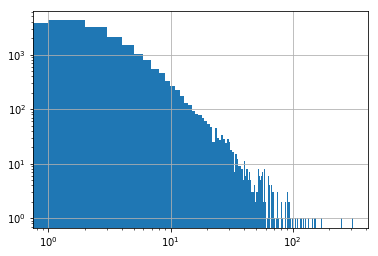

In [561]:
data_clean2.num_comments.hist(bins=311)
plt.yscale('log')
plt.xscale('log')

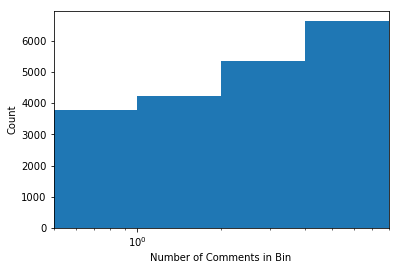

In [100]:
comment_bins = [0, 1, 2, 4, 400]
#comment_bins = [-1, 0.5, 1.5, 3.5, 400]
plt.hist(data_clean2.num_comments, bins=comment_bins)
plt.xlim([0.5, 8])
plt.xlabel('Number of Comments in Bin')
plt.ylabel('Count')
plt.xscale('log')

In [23]:
def BinNumComments(df, bins) :
    """ Bin the number of comments into the specified number of bins
    """
    import pandas as pd
    df_new = df.copy()
    categorized = pd.cut(df_new.num_comments, bins=bins, labels = False, include_lowest = True)
    df_new = df_new.assign(comment_category=categorized)
       
    return df_new.drop('num_comments', axis=1)

In [101]:
comment_bins = [0, 1, 2, 4, 400]
data_binned = BinNumComments(data_clean2, comment_bins)
data_binned.head(20)

,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,...,title_lsi_391,title_lsi_392,title_lsi_393,title_lsi_394,title_lsi_395,title_lsi_396,title_lsi_397,title_lsi_398,title_lsi_399,comment_category
0,4,14,2,2014,747,1,42,0,34,2,...,0.018861,0.017071,0.072441,-0.170715,0.014562,-0.159632,-0.087567,-0.011338,-0.089088,0
1,4,14,2,2014,789,5,72,0,43,4,...,0.039929,0.031977,0.027328,-0.022389,-0.001492,0.005747,0.035699,0.079924,-0.021723,0
2,4,14,2,2014,771,0,40,0,25,2,...,0.002005,0.008562,0.009517,-0.014396,-0.026986,0.006011,0.006036,0.001092,0.009211,0
3,4,13,2,2014,337,1,40,1,19,1,...,0.051516,0.045021,-0.036653,-0.048915,-0.128913,-0.112972,0.017297,0.007641,-0.114715,0
4,4,12,2,2014,671,0,16,0,0,0,...,-0.022786,-0.003111,0.047092,0.026543,0.023326,0.016933,-0.027857,0.001742,0.027733,0
5,4,11,2,2014,729,0,30,1,30,1,...,-0.019436,0.024791,-0.000926,0.006904,-0.036595,0.005975,0.013679,-0.015028,-0.028580,2
7,4,10,2,2014,2395,0,58,0,73,1,...,-0.003125,0.008174,-0.000003,-0.004750,-0.002226,-0.016211,-0.003436,-0.028263,0.006110,0
8,4,10,2,2014,146,1,52,0,6,2,...,0.004436,0.006774,-0.007566,-0.015258,-0.005960,-0.019844,-0.004404,0.006608,0.017378,0
9,4,10,2,2014,6343,0,32,0,116,1,...,0.039875,-0.013115,0.032891,-0.010807,-0.030286,0.009913,-0.009650,0.001028,0.009296,0
10,4,10,2,2014,1321,0,38,0,43,2,...,-0.003369,0.011222,0.010001,0.001473,0.018258,-0.004797,0.010304,0.005557,0.007022,0


## Train Model

In [129]:
from sklearn import ensemble, linear_model

class BuildClassificationModel() :
    
    def __init__(self, data_x, data_y, model_type = 'randomforest', test_frac = 0.2, fit_flag = True) :
        from sklearn import ensemble, linear_model
        from sklearn.model_selection import train_test_split
        from sklearn.svm import SVC
        
        (self.train_x, self.test_x, self.train_y, self.test_y) = train_test_split(
                    data_x, data_y, test_size = test_frac)
                
        if model_type == 'randomforest' :
            self.model = ensemble.RandomForestClassifier()
        elif model_type == 'gradientboostingclassifier' :
            self.model = ensemble.GradientBoostingClassifier()
        elif model_type == 'logisticregression' :
            self.model = linear_model.LogisticRegression()
        elif model_type == 'svc' :
            self.model = SVC(kernel='rbf', C=1e3, gamma=0.1)
        else :
            print('Model type "{}" is not defined'.format(model_type))
            return
        
        if fit_flag :
            print('{} on {} features.  Training on {} rows, validating on {}.'.format(model_type, self.train_x.shape[1], self.train_x.shape[0], self.test_x.shape[0]))
            self.model.fit(self.train_x, self.train_y)
        return
    
    def predict(self) :
        print('Accuracy: %.3f' % self.model.score(self.test_x, self.test_y))            

    def confusion_matrix(self, bins=None) :
        from sklearn.metrics import confusion_matrix
        cnf_matrix = confusion_matrix(self.test_y, 
            self.model.predict(self.test_x))
        plt.figure()
        if bins :
            plot_confusion_matrix(cnf_matrix, classes=bins, normalize=True)
        else :
            plot_confusion_matrix(cnf_matrix, normalize=True)
        
def TestClassificationModels(train_x, train_y, models_to_test, log_flag = False, bins = None) :
    "Train model on the models supplied in models_to_test"
    models = []
    for model in models_to_test :
        model_temp = BuildClassificationModel(train_x, train_y, model_type = model)
        model_temp.predict()
        models.append(model_temp)
        model_temp.confusion_matrix(bins=bins)
        print()
    return models

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Analyze models

In [30]:
train_x = data_binned.drop('comment_category', axis=1)
train_y = data_binned.comment_category

In [31]:
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test)

randomforest on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.346

logisticregression on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.403



In [37]:
model_binned_1_ranfor = BuildClassificationModel(train_x, train_y, 'randomforest')
model_binned_1_ranfor.predict()

randomforest on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.356


Normalized confusion matrix
[[ 0.69981001  0.07029766  0.07979734  0.150095  ]
 [ 0.66216216  0.08408408  0.08858859  0.16516517]
 [ 0.66761364  0.07244318  0.08664773  0.17329545]
 [ 0.64129401  0.06184586  0.1056137   0.19124643]]


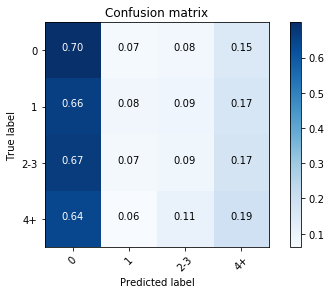

In [38]:
curr_bins = ['0', '1', '2-3', '4+']
model_binned_1_ranfor.confusion_matrix(curr_bins)

In [43]:
feature_importance = model_binned_1_ranfor.model.feature_importances_
feature_importance = zip(range(10), data_binned.columns, feature_importance)
feature_importance = sorted(feature_importance, key=lambda x: x[2], reverse=True)
for (x, y, z) in  feature_importance:
    print('{}  {} \t {}'.format(x, y, z))

1  created_hour 	 0.0019189979507370867
4  post_char_len 	 0.0018131030005933187
6  title_char_len 	 0.0012905329237180793
8  post_num_punc 	 0.0011673289700878148
7  title_num_qs 	 0.000990115923451372
0  created_dayofweek 	 0.0006120301417461025
9  title_num_punc 	 0.00043252097164445417
5  post_num_qs 	 0.00039385348783013376
2  created_month 	 0.0003592661550269426
3  created_year 	 0.0001904221301207147


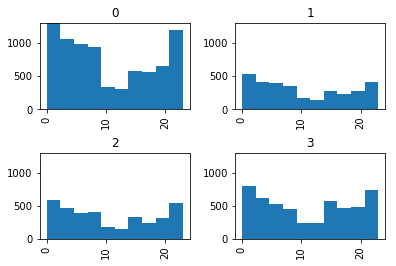

In [61]:
#data_binned.comment_category.hist(by=data_binned.created_hour)
ct = data_binned.created_hour.hist(by=data_binned.comment_category)
for x in ct :
    for y in x :
        y.set_ylim([0, 1300])

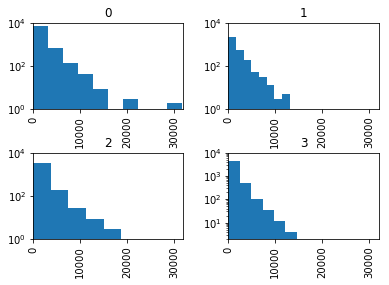

In [63]:
ct = data_binned.post_char_len.hist(by=data_binned.comment_category)
for x in ct :
    for y in x :
        y.set_yscale('log')
        y.set_ylim([0, 10**4])
        y.set_xlim([0, 32000])

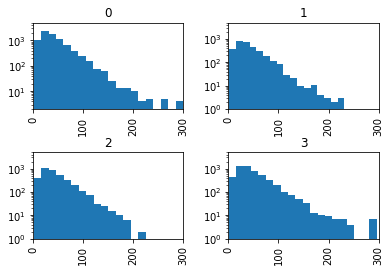

In [74]:
ct = data_binned.title_char_len.hist(by=data_binned.comment_category, bins=20)
for x in ct :
    for y in x :
        y.set_yscale('log')
        y.set_ylim([0, 5*10**3])
        y.set_xlim([0, 300])

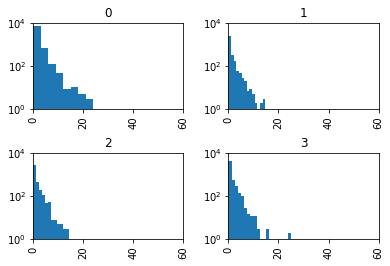

In [78]:
ct = data_binned.post_num_qs.hist(by=data_binned.comment_category, bins=20)
for x in ct :
    for y in x :
        y.set_yscale('log')
        y.set_ylim([0, 10000])
        y.set_xlim([0, 60])

In [79]:
data_binned.columns

Index(['created_dayofweek', 'created_hour', 'created_month', 'created_year',
       'post_char_len', 'post_num_qs', 'title_char_len', 'title_num_qs',
       'post_num_punc', 'title_num_punc',
       ...
       'title_lsi_391', 'title_lsi_392', 'title_lsi_393', 'title_lsi_394',
       'title_lsi_395', 'title_lsi_396', 'title_lsi_397', 'title_lsi_398',
       'title_lsi_399', 'comment_category'],
      dtype='object', length=817)

In [83]:
cols_to_drop = ['title_lsi_{}'.format(x) for x in range(100, 399)] + ['post_lsi_{}'.format(x) for x in range(100, 399)]
train_x = data_binned.drop(['comment_category']+cols_to_drop, axis=1)
train_y = data_binned.comment_category

model_binned_2_ranfor = BuildClassificationModel(train_x, train_y, 'randomforest')
model_binned_2_ranfor.predict()

randomforest on 218 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.332


Normalized confusion matrix
[[ 0.69981001  0.07029766  0.07979734  0.150095  ]
 [ 0.66216216  0.08408408  0.08858859  0.16516517]
 [ 0.66761364  0.07244318  0.08664773  0.17329545]
 [ 0.64129401  0.06184586  0.1056137   0.19124643]]


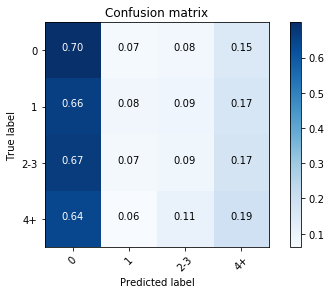

In [84]:
model_binned_1_ranfor.confusion_matrix(curr_bins)

In [90]:
cols_to_drop = ['title_lsi_{}'.format(x) for x in range(30, 399)] + ['post_lsi_{}'.format(x) for x in range(30, 399)]
train_x = data_binned.drop(['comment_category']+cols_to_drop, axis=1)
train_y = data_binned.comment_category

model_binned_3_ranfor = BuildClassificationModel(train_x, train_y, 'randomforest')
model_binned_3_ranfor.predict()

randomforest on 78 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.357


Normalized confusion matrix
[[ 0.69981001  0.07029766  0.07979734  0.150095  ]
 [ 0.66216216  0.08408408  0.08858859  0.16516517]
 [ 0.66761364  0.07244318  0.08664773  0.17329545]
 [ 0.64129401  0.06184586  0.1056137   0.19124643]]


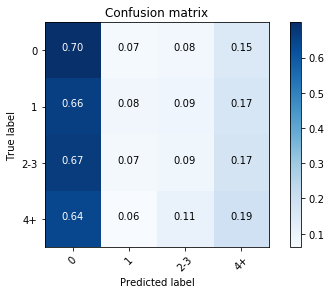

In [91]:
model_binned_1_ranfor.confusion_matrix(curr_bins)

## Look at different binnings

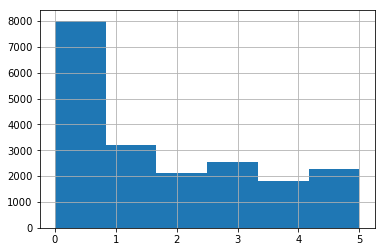

In [107]:
comment_bins = [0, 1, 2, 3, 5, 8, 400]
data_binned_6 = BinNumComments(data_clean2, comment_bins)
data_binned_6.comment_category.hist(bins=len(comment_bins)-1)

In [102]:
train_x = data_binned_6.drop('comment_category', axis=1)
train_y = data_binned_6.comment_category

randomforest on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.339
Normalized confusion matrix
[[ 0.75107825  0.09242144  0.04313001  0.04990758  0.02772643  0.03573629]
 [ 0.75180375  0.09090909  0.04040404  0.05483405  0.02164502  0.04040404]
 [ 0.75        0.0975      0.0325      0.045       0.0175      0.0575    ]
 [ 0.76171079  0.08757637  0.04684318  0.04276986  0.02443992  0.03665988]
 [ 0.74174174  0.11711712  0.03003003  0.03603604  0.03003003  0.04504505]
 [ 0.71304348  0.08695652  0.05652174  0.06304348  0.01956522  0.06086957]]

logisticregression on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.384
Normalized confusion matrix
[[ 0.91340076  0.02654867  0.00758534  0.00948167  0.01201011  0.03097345]
 [ 0.90327613  0.04056162  0.          0.01560062  0.01872075  0.02184087]
 [ 0.91503268  0.02396514  0.0043573   0.0087146   0.02178649  0.02614379]
 [ 0.88353414  0.03012048  0.01606426  0.01004016  0.01004016  0.0502008 ]
 [ 0

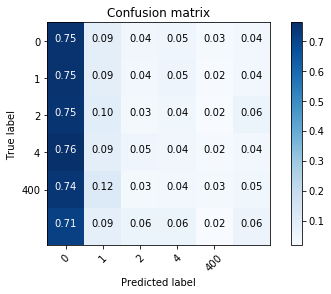

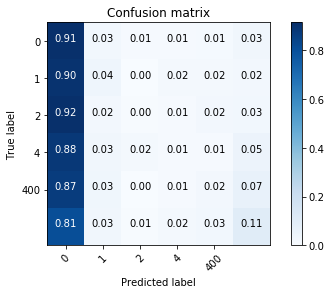

In [104]:
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

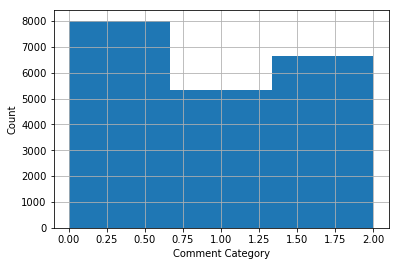

In [113]:
comment_bins = [0, 1, 3, 400]
data_binned_3 = BinNumComments(data_clean2, comment_bins)
data_binned_3.comment_category.hist(bins=len(comment_bins)-1)
plt.xlabel('Comment Category')
plt.ylabel('Count')

randomforest on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.368
Normalized confusion matrix
[[ 0.5431566   0.20468557  0.25215783]
 [ 0.52930233  0.20186047  0.26883721]
 [ 0.49654643  0.21488872  0.28856485]]

logisticregression on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.434
Normalized confusion matrix
[[ 0.65184721  0.07576706  0.27238572]
 [ 0.56601942  0.08446602  0.34951456]
 [ 0.46904588  0.08885652  0.4420976 ]]



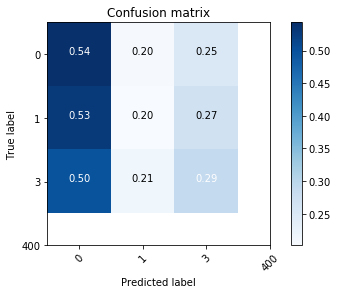

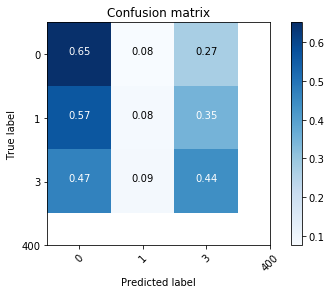

In [111]:
train_x = data_binned_3.drop('comment_category', axis=1)
train_y = data_binned_3.comment_category

models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

logisticregression on 816 features.  Training on 16000 rows, validating on 4000.
Normalized confusion matrix
[[ 0.63029925  0.07418953  0.29551122]
 [ 0.5526075   0.09515096  0.35224154]
 [ 0.46124328  0.08595549  0.45280123]]


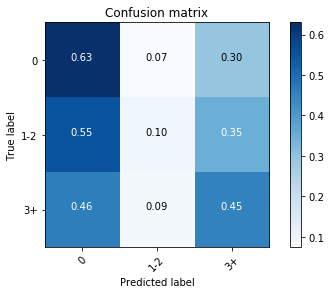

In [112]:
model_binned_3_logreg = BuildClassificationModel(train_x, train_y, 'logisticregression')
model_binned_3_logreg.confusion_matrix(['0', '1-2', '3+'])

randomforest on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.551
Normalized confusion matrix
[[ 0.75279893  0.24720107]
 [ 0.70401811  0.29598189]]

logisticregression on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.577
Normalized confusion matrix
[[ 0.75324095  0.24675905]
 [ 0.64662507  0.35337493]]



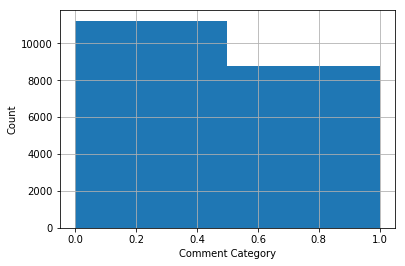

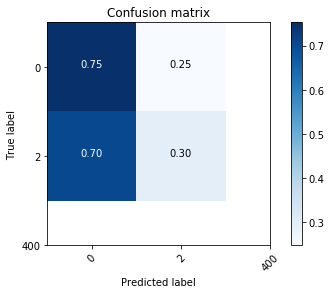

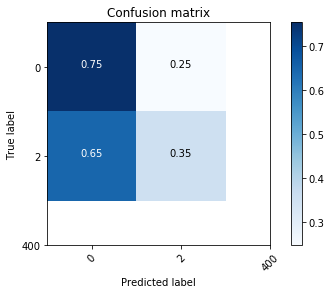

In [120]:
comment_bins = [0, 2, 400]
data_binned_2 = BinNumComments(data_clean2, comment_bins)
data_binned_2.comment_category.hist(bins=len(comment_bins)-1)
plt.xlabel('Comment Category')
plt.ylabel('Count')

train_x = data_binned_2.drop('comment_category', axis=1)
train_y = data_binned_2.comment_category

models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

Now with 0 vs. everything else.

randomforest on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.535
Normalized confusion matrix
[[ 0.42028061  0.57971939]
 [ 0.39103618  0.60896382]]

logisticregression on 816 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.601
Normalized confusion matrix
[[ 0.30577508  0.69422492]
 [ 0.19278132  0.80721868]]



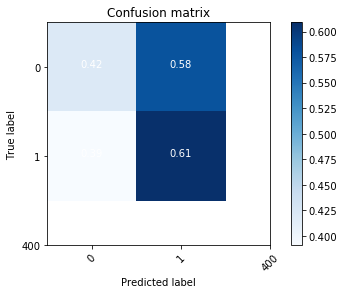

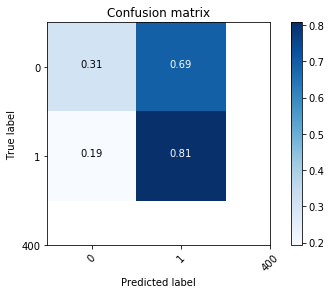

In [146]:
comment_bins = [0, 1, 400]
data_binned_2 = BinNumComments(data_clean2, comment_bins)

train_x = data_binned_2.drop('comment_category', axis=1)
train_y = data_binned_2.comment_category

models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

In [118]:
index = 10000
print(data_clean.num_comments.iloc[index], data_clean.title.iloc[index],
     data_clean.selftext.iloc[index], data_clean.created_hour.iloc[index], sep='\n');

6
I think about things too much....
I've been thinking so much about life lately, and I just feel like what's the point of making a life for yourself when you will not make a true difference in the world? In the grand scheme of the universe, we represent far less than one percent. We are the greatest beings known to us and yet we find the most retarded reasons to fight over. We put down our brother and sisters because they are different in who they decide to love. Even the belief of spiritual beings or lack thereof. We are all human beings. We should all be equal and together in love and happiness. All this thinking is making me really depressed and I'm scared. I've considered suicide before but I will never actually do it.

I am not going to get started on my personal things that also make me depressed. That's a whole nother story...
4


Normalized confusion matrix
[[ 0.87798896  0.00245248  0.00429185  0.11526671]
 [ 0.7983871   0.0016129   0.00322581  0.19677419]
 [ 0.79694019  0.          0.00278164  0.20027816]
 [ 0.71650485  0.          0.00485437  0.27864078]]


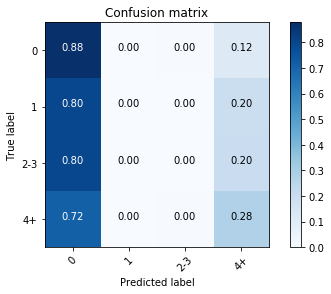

In [586]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2-3', '4+'], normalize=True)

Do grid search for random forest parameters.  The first function is from sklearn example, the following code modified from that.

In [119]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [124]:
def CreateTrainingData(df, col = 'comment_category') :
    "split dataframe into x and y data, where y is given by col"
    train_x = df.drop([col], axis=1)
    train_y = df[col]
    return (train_x, train_y)

In [143]:
from scipy.stats import randint as sp_randint
# specify parameters and distributions to sample from
param_dist_rf = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "class_weight": ['balanced', 'balanced_subsample', None],
              "n_estimators": [10, 15, 20],
             }

In [152]:
param_dist_lr = {"C": [1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10, 30, 100, 300],
              "class_weight": ['balanced', None],
             "penalty": ['l1', 'l2'],
             }

### 6 comment bins

In [150]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
comment_bins_6 = [0, 1, 2, 3, 5, 8, 400]
data_binned_6 = BinNumComments(data_clean2, comment_bins_6)
#data_binned_6.comment_category.hist(bins=len(comment_bins_6)-1)
(train_x, train_y) = CreateTrainingData(data_binned_6)

In [144]:
model_6bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_6bins.model, param_distributions=param_dist_rf, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 174.27 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 15}

Model with rank: 1
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}

Model with rank: 1
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 20}

Model with rank: 1
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 4, 'min_

The following cell, with n_iter_search = 20, takes more than 90 minutes to run.  So abort and tyr again with 10 iterations.

In [153]:
model_6bins = BuildClassificationModel(train_x, train_y, 'logisticregression', fit_flag=False)
n_iter_search = 10
random_search = RandomizedSearchCV(model_6bins.model, param_distributions=param_dist_lr, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

KeyboardInterrupt: 

### 4 comment bins

In [ ]:
comment_bins_4 = [0, 1, 2, 4, 400]
data_binned_4 = BinNumComments(data_clean2, comment_bins_4)
#data_binned_4.comment_category.hist(bins=len(comment_bins_4)-1)
(train_x, train_y) = CreateTrainingData(data_binned_4)

In [145]:
model_4bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_4bins.model, param_distributions=param_dist_rf, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 137.05 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 10}

Model with rank: 1
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.401 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10}



In [ ]:
model_4bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_4bins.model, param_distributions=param_dist_lr, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

### 3 comment bins

In [ ]:
comment_bins_3 = [0, 1, 3, 400]
data_binned_3 = BinNumComments(data_clean2, comment_bins_3)
data_binned_3.comment_category.hist(bins=len(comment_bins_3)-1)

RandomizedSearchCV took 117.89 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.599 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.599 (std: 0.000)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.587 (std: 0.008)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 15}



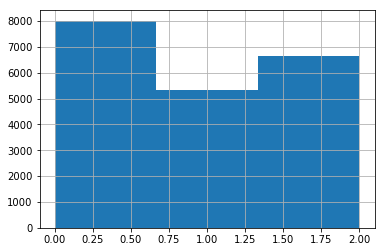

In [147]:
model_3bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_3bins.model, param_distributions=param_dist_rf, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

In [ ]:
model_3bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_3bins.model, param_distributions=param_dist_lr, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

### 2 comment bins

In [ ]:
comment_bins_2 = [0, 2, 400]
data_binned_2 = BinNumComments(data_clean2, comment_bins_2)
#data_binned_2.comment_category.hist(bins=len(comment_bins_2)-1)

In [148]:
model_2bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_2bins.model, param_distributions_rf=param_dist, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 104.80 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.600 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.599 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.599 (std: 0.000)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}



In [ ]:
model_2bins = BuildClassificationModel(train_x, train_y, 'randomforest', fit_flag=False)
n_iter_search = 20
random_search = RandomizedSearchCV(model_2bins.model, param_distributions_lr=param_dist, n_iter=n_iter_search)

start = time()
random_search.fit(train_x, train_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# Sentiment analysis

Use the Vader sentiment analysis from NLTK.

In [162]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

for x in range(10) :
    title_sia = sia.polarity_scores(titles_raw[x])
    post_sia = sia.polarity_scores(posts_raw[x])
    
    print('{}:\n{}\n\t{}\n{}\n\t{}\n'.format(x, title_sia, 
                        titles_raw[x], post_sia, posts_raw[x]))

0:
{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'compound': 0.3612}
	I feel like my brain doesn't work anymore.
{'neg': 0.207, 'neu': 0.769, 'pos': 0.025, 'compound': -0.9712}
	I can't think straight, I can't concentrate, I feel like I have brain damage and my IQ is dropping. I forget everything in a second; tell me your name and a minute later it's gone. 

I'm in college, and that's a joke; I failed most of my classes last semester, and I'm on the verge of failing the 2 I'm taking this semester. I decided to go to school only half time this semester, and I can't even do that. And it's only community college - who fails community college? I want to drop out. 

I can't do this anymore. I can't even have conversations with people anymore because I can't think of anything to say. I've been screwing up at work because I keep missing simple things. I don't know what to do. It's like I can feel my brain wasting away.

1:
{'neg': 0.206, 'neu': 0.794, 'pos': 0.0, 'compound': -0.5216}
	She's the gi

In [227]:
def AddSentimentScore(df, posts_raw, titles_raw) :
    """Add Vader sentiment scores, all outputs (compound, positive, 
        negative, and neutral) to the specified dataframe
    """
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    sia_ps = SIA().polarity_scores
    
    posts_sent = []
    for post in posts_raw : 
        temp = sia_ps(post)
        posts_sent.append([temp[k] for k in sorted(temp.keys())])
            
    titles_sent = []
    for title in titles_raw :
        temp = sia_ps(title)
        titles_sent.append([temp[k] for k in sorted(temp.keys())])
    
    df_new = df.copy()
    df_new['title_compound'] = [t[0] for t in titles_sent]
    df_new['title_neg'] = [t[1] for t in titles_sent]
    df_new['title_neu'] = [t[2] for t in titles_sent]
    df_new['title_pos'] = [t[3] for t in titles_sent]
    
    df_new['post_compound'] = [t[0] for t in posts_sent]
    df_new['post_neg'] = [t[1] for t in posts_sent]
    df_new['post_neu'] = [t[2] for t in posts_sent]
    df_new['post_pos'] = [t[3] for t in posts_sent]
    
    return df_new       

In [318]:
data_sentiment = AddSentimentScore(data_clean, posts_raw, titles_raw)

In [231]:
columns = ['title_compound', 'title_neg', 'title_neu', 'title_pos', 
           'post_compound', 'post_neg', 'post_neu', 'post_pos']
data_new = data_binned_4.copy()
for col in columns :
    data_new[col] = data_sentiment[col]
data_new.head()

,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,...,title_lsi_399,comment_category,title_compound,title_neg,title_neu,title_pos,post_compound,post_neg,post_neu,post_pos
0,4,14,2,2014,747,1,42,0,34,2,...,-0.089088,0,0.3612,0.000,0.706,0.294,-0.9712,0.207,0.769,0.025
1,4,14,2,2014,789,5,72,0,43,4,...,-0.021723,0,-0.5216,0.206,0.794,0.000,0.9900,0.125,0.559,0.317
2,4,14,2,2014,771,0,40,0,25,2,...,0.009211,0,0.0000,0.000,1.000,0.000,0.9226,0.152,0.630,0.218
3,4,13,2,2014,337,1,40,1,19,1,...,-0.114715,0,-0.5423,0.333,0.667,0.000,-0.7227,0.119,0.853,0.028
4,4,12,2,2014,671,0,16,0,0,0,...,0.027733,0,-0.1779,0.362,0.638,0.000,-0.9501,0.308,0.539,0.153


randomforest on 824 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.359
Normalized confusion matrix
[[ 0.69559826  0.0700558   0.0799752   0.15437074]
 [ 0.676783    0.07738998  0.08497724  0.16084977]
 [ 0.63028649  0.08594816  0.08049113  0.20327422]
 [ 0.62211055  0.08341709  0.08944724  0.20502513]]

logisticregression on 824 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.405
Normalized confusion matrix
[[ 0.79340938  0.02217997  0.02661597  0.15779468]
 [ 0.73030303  0.02272727  0.03030303  0.21666667]
 [ 0.74212034  0.02292264  0.0243553   0.21060172]
 [ 0.62969925  0.02067669  0.03383459  0.31578947]]



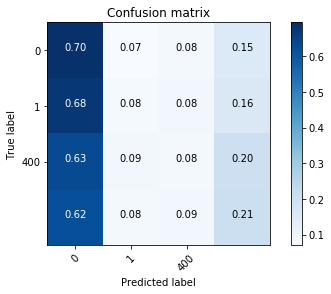

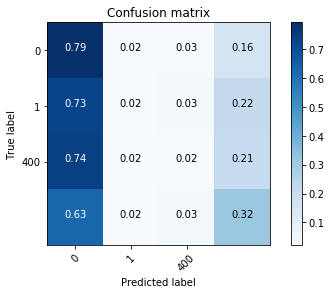

In [232]:
(train_x, train_y) = CreateTrainingData(data_new)
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

# Limit to first few posts

Restrict data to only the first several posts of each author.

In [241]:
data_temp = pd.DataFrame( pickle.load( open(file_load, 'rb')) )

In [272]:
authors = {}
def compile_author_posts(row, authors) :
    "map function that compiles the times each author poster in a separate dictionary"
    if row.author in authors :
        authors[row.author].append(row.created_utc)
    else :
        authors[row.author] = [row.created_utc]
    return

delete_me = data_temp.apply(compile_author_posts, args=(authors,), axis=1)

In [289]:
num_posts = []
for (key, value) in authors.items() :
    if key == '[deleted]' :
        print(key, len(value))
    elif len(value) > 100 :
        print(key, len(value), value)
    else :
        num_posts.append(len(value))

[deleted] 26506


Verify that this gives the same results as when computing it directly from the dataframe.

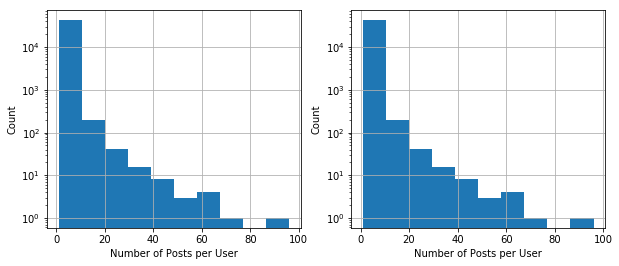

In [288]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))

plt.hist(num_posts)#, ax = axes[0])
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Posts per User')
axes[1].set_ylabel('Count')
axes[1].grid('on')

data_temp.author.value_counts()[1:].hist(ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Number of Posts per User')
axes[0].set_ylabel('Count')

In [291]:
test = [1234, 3245345, 29384524590]
test.index(3245345)

1

In [294]:
def flag_valid_posts(row, authors) :
    "Create a new column with how many posts the author has written so far"
    num_prev = authors[row.author].index(row.created_utc)
    return num_prev

data_temp['num_posts_so_far'] = data_temp.apply(flag_valid_posts, args=(authors,), axis=1)

In [319]:
len(data_temp[data_temp['num_posts_so_far']<4])

57133

In [317]:
temp = data_binned_4.join(data_temp.num_posts_so_far, how='left')

In [320]:
columns = ['title_compound', 'title_neg', 'title_neu', 'title_pos', 
           'post_compound', 'post_neg', 'post_neu', 'post_pos']
data_new = temp.copy()
for col in columns :
    data_new[col] = data_sentiment[col]

Run models on only first posts.

randomforest on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.305
Normalized confusion matrix
[[ 0.55223881  0.09414466  0.11940299  0.23421355]
 [ 0.54198473  0.08905852  0.08396947  0.28498728]
 [ 0.54273504  0.11965812  0.10897436  0.22863248]
 [ 0.53519062  0.09384164  0.12316716  0.24780059]]

logisticregression on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.374
Normalized confusion matrix
[[ 0.65906499  0.04104903  0.0695553   0.23033067]
 [ 0.59653465  0.03712871  0.07178218  0.29455446]
 [ 0.54356846  0.03526971  0.08921162  0.33195021]
 [ 0.48387097  0.02764977  0.07834101  0.41013825]]



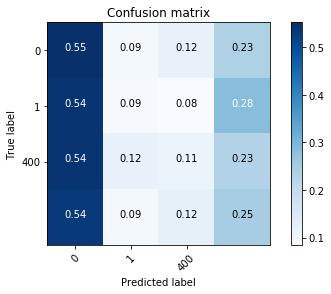

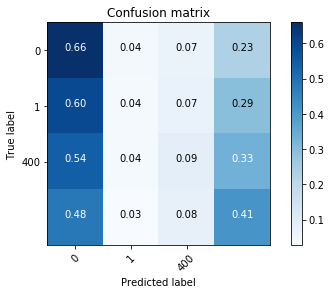

In [321]:
data_new2 = data_new[data_new.num_posts_so_far < 1]

(train_x, train_y) = CreateTrainingData(data_new)
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

randomforest on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.309
Normalized confusion matrix
[[ 0.57562077  0.10609481  0.11173815  0.20654628]
 [ 0.54881266  0.09234828  0.10026385  0.2585752 ]
 [ 0.60208333  0.08125     0.10833333  0.20833333]
 [ 0.5426009   0.10313901  0.13153961  0.22272048]]

logisticregression on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.383
Normalized confusion matrix
[[ 0.64432432  0.03459459  0.06162162  0.25945946]
 [ 0.57446809  0.04521277  0.05319149  0.32712766]
 [ 0.52024291  0.04251012  0.09311741  0.34412955]
 [ 0.47011309  0.0371567   0.06300485  0.42972536]]



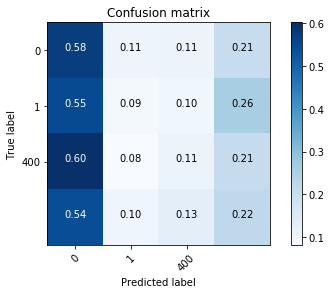

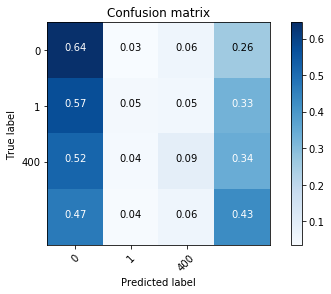

In [322]:
data_new2 = data_new[data_new.num_posts_so_far < 2]

(train_x, train_y) = CreateTrainingData(data_new)
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

randomforest on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.325
Normalized confusion matrix
[[ 0.58628319  0.0840708   0.11615044  0.21349558]
 [ 0.58524173  0.09669211  0.11704835  0.20101781]
 [ 0.56277056  0.11038961  0.12121212  0.20562771]
 [ 0.54198473  0.08854962  0.12519084  0.24427481]]

logisticregression on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.368
Normalized confusion matrix
[[ 0.6556213   0.04497041  0.06035503  0.23905325]
 [ 0.62383178  0.02803738  0.05841121  0.28971963]
 [ 0.53579176  0.04338395  0.06724512  0.35357918]
 [ 0.45294118  0.04705882  0.07058824  0.42941176]]



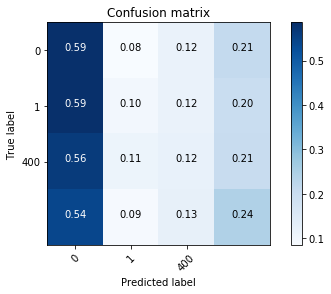

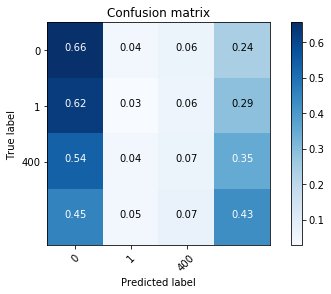

In [323]:
data_new2 = data_new[data_new.num_posts_so_far < 4]

(train_x, train_y) = CreateTrainingData(data_new)
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

randomforest on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.329
Normalized confusion matrix
[[ 0.62840909  0.09090909  0.11477273  0.16590909]
 [ 0.55773956  0.11793612  0.12039312  0.2039312 ]
 [ 0.57823129  0.09750567  0.12244898  0.20181406]
 [ 0.56268222  0.10495627  0.12973761  0.20262391]]

logisticregression on 825 features.  Training on 9653 rows, validating on 2414.
Accuracy: 0.357
Normalized confusion matrix
[[ 0.67502987  0.04778973  0.07287933  0.20430108]
 [ 0.57831325  0.04819277  0.05542169  0.31807229]
 [ 0.53941909  0.07676349  0.07053942  0.31327801]
 [ 0.50588235  0.05588235  0.08088235  0.35735294]]



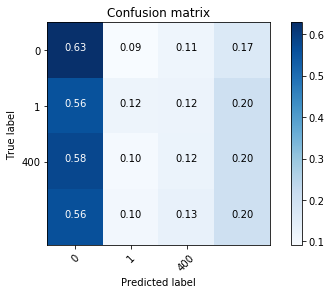

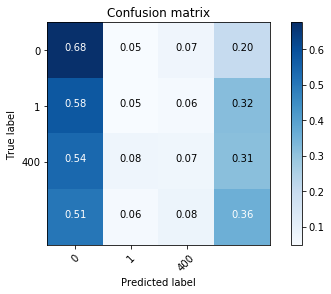

In [332]:
data_new2 = data_new[data_new.num_posts_so_far > 7]

(train_x, train_y) = CreateTrainingData(data_new)
models_to_test = ['randomforest', 'logisticregression']
models = TestClassificationModels(train_x, train_y, models_to_test, bins=comment_bins)

Plot learning curve, to see if the results are getting better with more data.  [This code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) taken from sklearn documentation.

In [324]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Learning rate shows that more data does not solve this problem: it's basically flat across here.  In other words, a hard problem.  This was also flat for 4 bins.

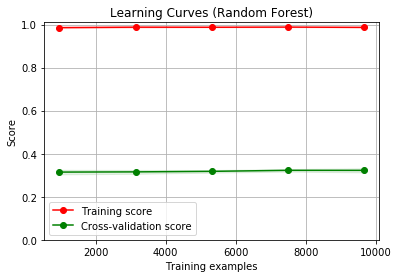

In [331]:
from sklearn import ensemble

data_new2 = data_new[data_new.num_posts_so_far < 1]
(train_x, train_y) = CreateTrainingData(data_new)

title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = ensemble.RandomForestClassifier()
plot_learning_curve(estimator, title, train_x, train_y, ylim=(0, 1.01), 
                    cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.show()